In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from collections import OrderedDict
from nltk.stem import WordNetLemmatizer 
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords
from scipy.sparse import hstack,csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
sns.set()
import plotly.offline as py


# **Okay Let's Begin 1 2 3...**
We are done with importing our long list of libraries 
(Can assure you that all of them are being used in this notebook and I did not import them for showing off ;)
## Time for a Exploration!!

In [5]:
df=pd.read_csv("fake_job_postings.csv")

In [6]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### **So now we can see the data that we have and the various headers under which its categorised** 
Take a moment to internalize the data and then on to our next step


---



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [8]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

### The dataset is highly imbalanced
As we have majority of genuine job posts, but that's sign of relief for all of those who are looking for jobs

In [9]:
df["title"].nunique()

11231

In [10]:
split_location=df["location"].apply(lambda x:str(x).strip().split(','))
split_location=split_location.apply(pd.Series)

### Spliting location in country, state and city columns

In [11]:
split_location

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,US,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NZ,,Auckland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,IA,Wever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,DC,Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,FL,Fort Worth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,CA,ON,Toronto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17876,US,PA,Philadelphia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17877,US,TX,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17878,NG,LA,Lagos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We got many many fields with NaN value which doesnt looks good
### I need to see if we have the data available for the locations
So I will try to see if in the 

```
split_location 
```
Do we have enough data to fill in the Country, State and City or not.


In [12]:
split_location[~(split_location[4].isnull())]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
733,US,AL,Birmingham,Montgomery,Atlanta Ga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1725,US,TX,Austin,San Antonio,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4396,US,MI,Hartford,Paw Paw,Lawton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480,US,CA,San Jose,SFO,Austin,OH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4527,US,NJ,Lakewood,Brick,Toms River,Jackson,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4650,US,FL,Central Fl,Nort Fl,Georgia,Alabama,Tennessee,South Carolina,North Carolina,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11987,US,CA,Los Angeles,Anaheim,San Diego,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12383,NL,ZH,Rotterdam,The Hague,Utrecht,Amsterdam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12467,US,NJ,Lakewood,Brick,Toms River,Jackson,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13181,US,CA,Los Angeles,California,San Francisco,California,San Jose,California,Manhattan,New York,Las Vegas,Nevada,Phoenix,Arizona,San Diego,California


### **Interesting Insight:** *Some* jobs offers are available in multiple locations

In [13]:
df['country']=split_location[0]

In [14]:
df['location_count']=df["location"].apply(lambda x:str(x).split(', '))

In [15]:
df['location_count']=df['location_count'].apply(lambda x:max(len(x)-2,0))

### Now I am interested to look how many jobs are avaialable in multiple locations
And I will use a simple bar graph to plot my results

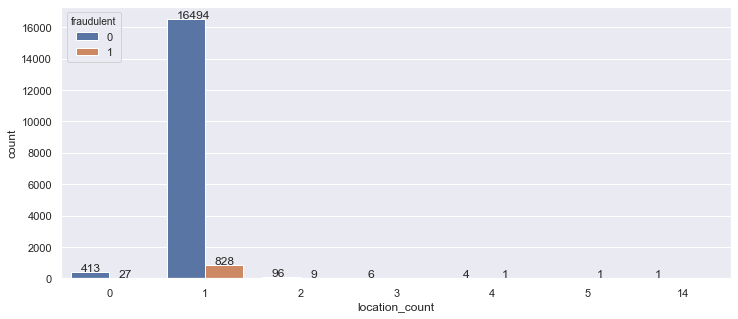

In [16]:
plt.figure(figsize=(12,5))
ax=sns.countplot(x='location_count',data=df,hue='fraudulent')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

In [17]:
df[((df['telecommuting']==1)&(df['location']!='none'))]['job_id'].count()

767

Here Telecommuting means "Work from Home" or "Virtual location" so if thats true than we can have empty job location 

In [18]:
df[((df['telecommuting']==0)&(df['location'].isnull()))]['job_id'].count()

325

<p> But Missing location does not mean work from home</p>

In [19]:
df['null_count']=df.isnull().sum(axis=1)

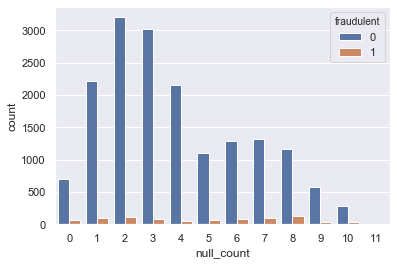

In [20]:
sns.countplot(x='null_count',data=df,hue='fraudulent');

In [21]:
# Map alpha 2 to corresponding alpha 3 country code
country_code_mapping = {"BD": "BGD", "BE": "BEL", "BF": "BFA", "BG": "BGR", "BA": "BIH", "BB": "BRB", "WF": "WLF", "BL": "BLM", "BM": "BMU", "BN": "BRN", "BO": "BOL", "BH": "BHR", "BI": "BDI", "BJ": "BEN", "BT": "BTN", "JM": "JAM", "BV": "BVT", "BW": "BWA", "WS": "WSM", "BQ": "BES", "BR": "BRA", "BS": "BHS", "JE": "JEY", "BY": "BLR", "BZ": "BLZ", "RU": "RUS", "RW": "RWA", "RS": "SRB", "TL": "TLS", "RE": "REU", "TM": "TKM", "TJ": "TJK", "RO": "ROU", "TK": "TKL", "GW": "GNB", "GU": "GUM", "GT": "GTM", "GS": "SGS", "GR": "GRC", "GQ": "GNQ", "GP": "GLP", "JP": "JPN", "GY": "GUY", "GG": "GGY", "GF": "GUF", "GE": "GEO", "GD": "GRD", "GB": "GBR", "GA": "GAB", "SV": "SLV", "GN": "GIN", "GM": "GMB", "GL": "GRL", "GI": "GIB", "GH": "GHA", "OM": "OMN", "TN": "TUN", "JO": "JOR", "HR": "HRV", "HT": "HTI", "HU": "HUN", "HK": "HKG", "HN": "HND", "HM": "HMD", "VE": "VEN", "PR": "PRI", "PS": "PSE", "PW": "PLW", "PT": "PRT", "SJ": "SJM", "PY": "PRY", "IQ": "IRQ", "PA": "PAN", "PF": "PYF", "PG": "PNG", "PE": "PER", "PK": "PAK", "PH": "PHL", "PN": "PCN", "PL": "POL", "PM": "SPM", "ZM": "ZMB", "EH": "ESH", "EE": "EST", "EG": "EGY", "ZA": "ZAF", "EC": "ECU", "IT": "ITA", "VN": "VNM", "SB": "SLB", "ET": "ETH", "SO": "SOM", "ZW": "ZWE", "SA": "SAU", "ES": "ESP", "ER": "ERI", "ME": "MNE", "MD": "MDA", "MG": "MDG", "MF": "MAF", "MA": "MAR", "MC": "MCO", "UZ": "UZB", "MM": "MMR", "ML": "MLI", "MO": "MAC", "MN": "MNG", "MH": "MHL", "MK": "MKD", "MU": "MUS", "MT": "MLT", "MW": "MWI", "MV": "MDV", "MQ": "MTQ", "MP": "MNP", "MS": "MSR", "MR": "MRT", "IM": "IMN", "UG": "UGA", "TZ": "TZA", "MY": "MYS", "MX": "MEX", "IL": "ISR", "FR": "FRA", "IO": "IOT", "SH": "SHN", "FI": "FIN", "FJ": "FJI", "FK": "FLK", "FM": "FSM", "FO": "FRO", "NI": "NIC", "NL": "NLD", "NO": "NOR", "NA": "NAM", "VU": "VUT", "NC": "NCL", "NE": "NER", "NF": "NFK", "NG": "NGA", "NZ": "NZL", "NP": "NPL", "NR": "NRU", "NU": "NIU", "CK": "COK", "XK": "XKX", "CI": "CIV", "CH": "CHE", "CO": "COL", "CN": "CHN", "CM": "CMR", "CL": "CHL", "CC": "CCK", "CA": "CAN", "CG": "COG", "CF": "CAF", "CD": "COD", "CZ": "CZE", "CY": "CYP", "CX": "CXR", "CR": "CRI", "CW": "CUW", "CV": "CPV", "CU": "CUB", "SZ": "SWZ", "SY": "SYR", "SX": "SXM", "KG": "KGZ", "KE": "KEN", "SS": "SSD", "SR": "SUR", "KI": "KIR", "KH": "KHM", "KN": "KNA", "KM": "COM", "ST": "STP", "SK": "SVK", "KR": "KOR", "SI": "SVN", "KP": "PRK", "KW": "KWT", "SN": "SEN", "SM": "SMR", "SL": "SLE", "SC": "SYC", "KZ": "KAZ", "KY": "CYM", "SG": "SGP", "SE": "SWE", "SD": "SDN", "DO": "DOM", "DM": "DMA", "DJ": "DJI", "DK": "DNK", "VG": "VGB", "DE": "DEU", "YE": "YEM", "DZ": "DZA", "US": "USA", "UY": "URY", "YT": "MYT", "UM": "UMI", "LB": "LBN", "LC": "LCA", "LA": "LAO", "TV": "TUV", "TW": "TWN", "TT": "TTO", "TR": "TUR", "LK": "LKA", "LI": "LIE", "LV": "LVA", "TO": "TON", "LT": "LTU", "LU": "LUX", "LR": "LBR", "LS": "LSO", "TH": "THA", "TF": "ATF", "TG": "TGO", "TD": "TCD", "TC": "TCA", "LY": "LBY", "VA": "VAT", "VC": "VCT", "AE": "ARE", "AD": "AND", "AG": "ATG", "AF": "AFG", "AI": "AIA", "VI": "VIR", "IS": "ISL", "IR": "IRN", "AM": "ARM", "AL": "ALB", "AO": "AGO", "AQ": "ATA", "AS": "ASM", "AR": "ARG", "AU": "AUS", "AT": "AUT", "AW": "ABW", "IN": "IND", "AX": "ALA", "AZ": "AZE", "IE": "IRL", "ID": "IDN", "UA": "UKR", "QA": "QAT", "MZ": "MOZ"}

In [22]:
df['country']=df['country'].apply(lambda x:country_code_mapping[x] if x!='nan' else 'nan')

In [69]:
fig = go.Figure(data=go.Choropleth(
    locations = df['country'].value_counts().index,
    z = df['country'].value_counts().values,
    text = df['country'].value_counts().index,
    colorscale = 'Blues',
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'job ads',
))

fig.update_layout(
    title_text='Total job ads',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),

)
py.iplot(fig)

#fig.show()

In [24]:
fraud_list=df[df['fraudulent']==1]['country'].value_counts().to_dict()
total_count_list=df['country'].value_counts().to_dict()
percent_fraud_dict={}
for country in total_count_list.keys():
    if country in fraud_list:
        percent_fraud_dict[country]=fraud_list[country]/total_count_list[country]*100
    else:
        percent_fraud_dict[country]=0
percent_fraud_dict=OrderedDict(sorted(percent_fraud_dict.items())) 

In [70]:
fig = go.Figure(data=go.Choropleth(
    locations = list(percent_fraud_dict.keys()),
    z = list(percent_fraud_dict.values()),
    text =  list(percent_fraud_dict.keys()),
    colorscale = 'Reds',
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Job ads percent',
))

fig.update_layout(
    title_text='Country wise Percentage of fraudulent job ads',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),

)
py.iplot(fig)


In [26]:
df['department'].value_counts().head(20)

Sales                     551
Engineering               487
Marketing                 401
Operations                270
IT                        225
Development               146
Product                   112
Information Technology     86
Technology                 76
Design                     76
Customer Service           73
Finance                    69
HR                         56
tech                       55
R&D                        54
Creative                   48
Retail                     45
Client Services            45
Product Development        36
Business Development       32
Name: department, dtype: int64

In [27]:
df['department'].fillna('none',inplace=True)

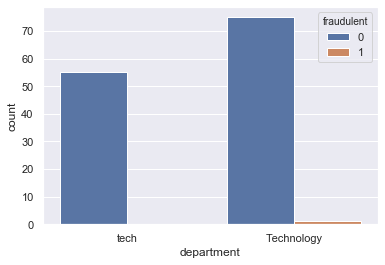

In [28]:
sns.countplot(x='department',data=df[((df['department']=='tech')|(df['department']=='Technology'))],hue='fraudulent');

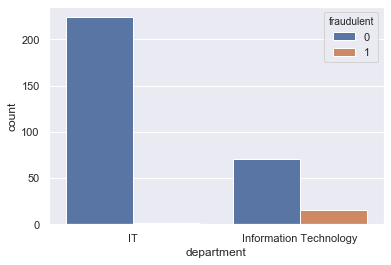

In [29]:
sns.countplot(x='department',data=df[((df['department']=='IT')|(df['department']=='Information Technology'))],hue='fraudulent');

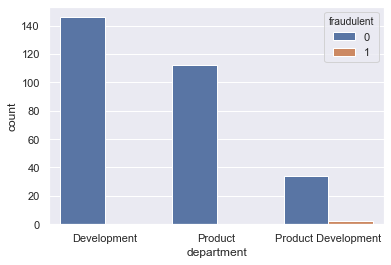

In [30]:
sns.countplot(x='department',data=df[((df['department']=='Development')|(df['department']=='Product')|(df['department']=='Product Development'))],hue='fraudulent');

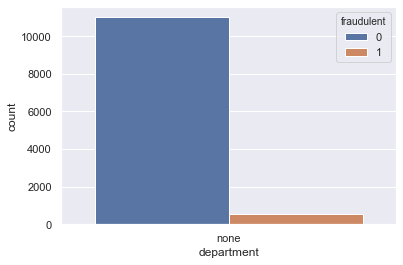

In [31]:
sns.countplot(x='department',data=df[df['department']=='none'],hue='fraudulent');

<p>There are a lot of jobs which have the same department but use different terms.Fraudulent ads seem to be biased towards a particular term for a department but this may also be due to fewer fraudulent ads.</p>
<p>Most of the authentic jobs also didn't specify the department.</p>

In [32]:
df['salary_range'].nunique()

874

In [33]:
df[df['salary_range'].notnull()]['salary_range']

6          20000-28000
10       100000-120000
15       120000-150000
23       100000-120000
31         50000-65000
             ...      
17844              0-0
17849     80000-100000
17865      18000-20000
17867      18000-19000
17874     80000-100000
Name: salary_range, Length: 2868, dtype: object

In [34]:
salary=df['salary_range'].apply(lambda x:str(x).strip().split('-'))
salary=salary.apply(pd.Series)

In [35]:
# Function to check for non integer values
def int_check(x):
    try:
        int(x)
    except:
        if x!='nan':
            print(x)

In [36]:
salary[0].apply(int_check)

Oct
Oct
Jun
Oct
Dec


0        None
1        None
2        None
3        None
4        None
         ... 
17875    None
17876    None
17877    None
17878    None
17879    None
Name: 0, Length: 17880, dtype: object

In [37]:
def int_convert(x):
    try:
        return int(x)
    except:
        return 0

In [38]:
df['salary_lower_bound']=salary[0]
df['salary_lower_bound']=df['salary_lower_bound'].apply(int_convert)
df['salary_upper_bound']=salary[1]
df['salary_upper_bound']=df['salary_upper_bound'].apply(int_convert)

In [39]:
df['avg_salary']=(df['salary_upper_bound']+df['salary_lower_bound'])/2

In [40]:
px.histogram(data_frame=df[(df['avg_salary']<=100000)&(df['avg_salary']!=0)],x="avg_salary",color='fraudulent',marginal='rug')


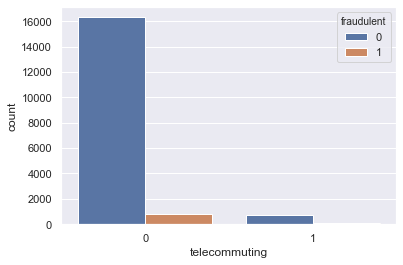

In [41]:
sns.countplot(x='telecommuting',data=df,hue='fraudulent');

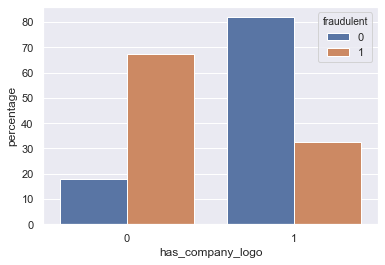

In [42]:
sns.barplot(x="has_company_logo", y="percentage", hue="fraudulent", data=df.groupby(['fraudulent'])['has_company_logo']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('has_company_logo'));

### As expected, most of the fraudulent job ads don't have a company logo.

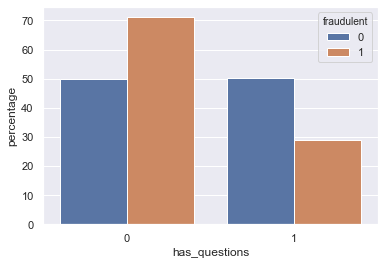

In [43]:
sns.barplot(x="has_questions", y="percentage", hue="fraudulent", data=df.groupby(['fraudulent'])['has_questions']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('has_questions'));

In [44]:
df['employment_type'].unique()

array(['Other', 'Full-time', nan, 'Part-time', 'Contract', 'Temporary'],
      dtype=object)

In [45]:
df['employment_type'].fillna("none",inplace=True)

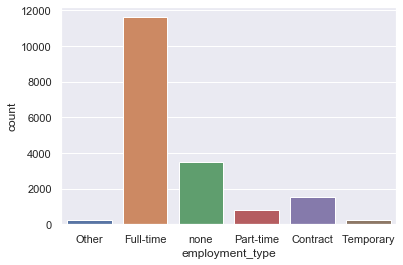

In [46]:
sns.countplot(x='employment_type',data=df);

In [47]:
df['required_experience'].unique()

array(['Internship', 'Not Applicable', nan, 'Mid-Senior level',
       'Associate', 'Entry level', 'Executive', 'Director'], dtype=object)

In [48]:
df[df['required_experience']=='Not Applicable'].head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education,industry,function,fraudulent,country,location_count,null_count,salary_lower_bound,salary_upper_bound,avg_salary
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,NaN,Marketing and Advertising,Customer Service,0,NZL,1,2,0,0,0.0
13,14,Installers,"US, FL, Orlando",none,NaN,Growing event production company providing sta...,"Event Industry Installers Needed!! (Orlando, F...","Valid driver's license,Somewhat Clean driving ...",NaN,0,...,Unspecified,Events Services,Other,0,USA,1,3,0,0,0.0
59,60,Product Visual Designer,"US, CA, San Francisco",none,NaN,"From the lands of Can Do, Roll Our Sleeves Up ...",Apcera is revolutionizing enterprise technolog...,RESPONSIBILITIES:Work with the UX architect's ...,Competitive salary &amp; equityGreat location ...,0,...,Unspecified,Information Technology and Services,Design,0,USA,1,2,0,0,0.0
94,95,WF17 9LU Customer Service Apprenticeship under...,"GB, , Birstall",none,NaN,Established on the principles that full time e...,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Future Prospects,0,...,High School or equivalent,NaN,Administrative,0,GBR,1,3,0,0,0.0
107,108,Senior Developer at a Startup Investment Studio,"GB, LND, London",FP,50000-70000,"Based in Hoxton, London, Forward Partners are ...",Forward Partners invest in very early stage e-...,About youYou should be expert in one language ...,NaN,0,...,Unspecified,Venture Capital & Private Equity,Information Technology,0,GBR,1,1,50000,70000,60000.0


In [49]:
df[df['required_experience'].isnull()].head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education,industry,function,fraudulent,country,location_count,null_count,salary_lower_bound,salary_upper_bound,avg_salary
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",none,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,...,NaN,NaN,NaN,0,USA,1,8,0,0,0.0
5,6,Accounting Clerk,"US, MD,",none,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,...,NaN,NaN,NaN,0,USA,1,10,0,0,0.0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",none,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,...,NaN,NaN,NaN,0,USA,1,7,0,0,0.0
11,12,Talent Sourcer (6 months fixed-term contract),"GB, LND, London",HR,NaN,Want to build a 21st century financial service...,TransferWise is the clever new way to move mon...,We’re looking for someone who:Proven track rec...,You will join one of Europe’s most hotly tippe...,0,...,NaN,NaN,NaN,0,GBR,1,6,0,0,0.0
17,18,Southend-on-Sea Traineeships Under NAS 16-18 Y...,"GB, SOS, Southend-on-Sea",none,NaN,Established on the principles that full time e...,Government funding is only available for 16-18...,16-18 year olds only due to government funding...,Career prospects.,0,...,NaN,NaN,NaN,0,GBR,1,7,0,0,0.0


<p>Missing required_experience value may indicate 'Not Applicable'</p>

In [50]:
df['required_experience'].fillna('Not Applicable',inplace=True)

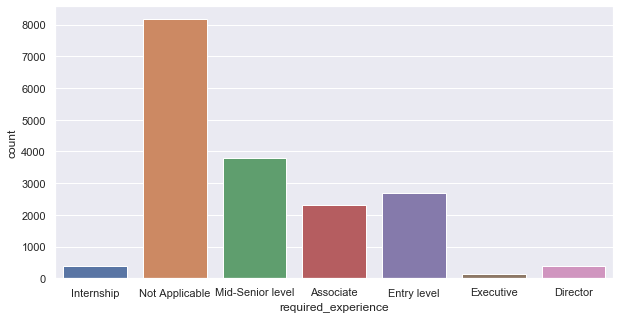

In [51]:
plt.figure(figsize=(10,5))
sns.countplot(x='required_experience',data=df);

In [52]:
df['required_education'].unique()

array([nan, "Bachelor's Degree", "Master's Degree",
       'High School or equivalent', 'Unspecified',
       'Some College Coursework Completed', 'Vocational', 'Certification',
       'Associate Degree', 'Professional', 'Doctorate',
       'Some High School Coursework', 'Vocational - Degree',
       'Vocational - HS Diploma'], dtype=object)

In [53]:
df['required_education'].fillna('Unspecified',inplace=True)

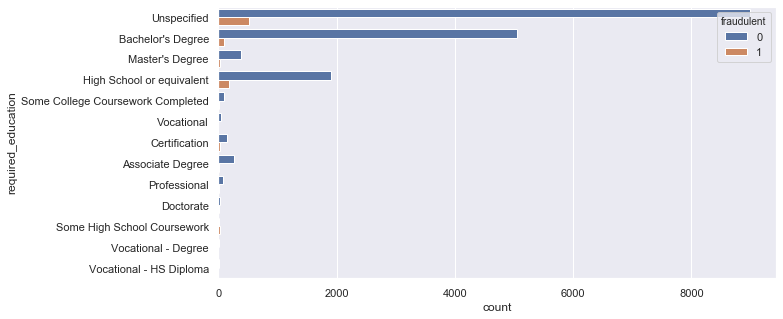

In [54]:
plt.figure(figsize=(10,5))
sns.countplot(y='required_education',data=df,hue='fraudulent');

In [55]:
df['industry'].unique()

array([nan, 'Marketing and Advertising', 'Computer Software',
       'Hospital & Health Care', 'Online Media',
       'Information Technology and Services', 'Financial Services',
       'Management Consulting', 'Events Services', 'Internet',
       'Facilities Services', 'Consumer Electronics',
       'Telecommunications', 'Consumer Services', 'Construction',
       'Oil & Energy', 'Education Management', 'Building Materials',
       'Banking', 'Food & Beverages', 'Food Production',
       'Health, Wellness and Fitness', 'Insurance', 'E-Learning',
       'Cosmetics', 'Staffing and Recruiting',
       'Venture Capital & Private Equity', 'Leisure, Travel & Tourism',
       'Human Resources', 'Pharmaceuticals', 'Farming', 'Legal Services',
       'Luxury Goods & Jewelry', 'Machinery', 'Real Estate',
       'Mechanical or Industrial Engineering',
       'Public Relations and Communications', 'Consumer Goods',
       'Medical Practice', 'Electrical/Electronic Manufacturing',
       'Hospita

In [56]:
df['industry'].fillna('not specified',inplace=True)

In [57]:
df['function'].unique()

array(['Marketing', 'Customer Service', nan, 'Sales',
       'Health Care Provider', 'Management', 'Information Technology',
       'Other', 'Engineering', 'Administrative', 'Design', 'Production',
       'Education', 'Supply Chain', 'Business Development',
       'Product Management', 'Financial Analyst', 'Consulting',
       'Human Resources', 'Project Management', 'Manufacturing',
       'Public Relations', 'Strategy/Planning', 'Advertising', 'Finance',
       'General Business', 'Research', 'Accounting/Auditing',
       'Art/Creative', 'Quality Assurance', 'Data Analyst',
       'Business Analyst', 'Writing/Editing', 'Distribution', 'Science',
       'Training', 'Purchasing', 'Legal'], dtype=object)

In [58]:
df['function'].fillna('not specified',inplace=True)

In [59]:
df[(df['company_profile'].isnull())&(df['fraudulent']==0)]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education,industry,function,fraudulent,country,location_count,null_count,salary_lower_bound,salary_upper_bound,avg_salary
5,6,Accounting Clerk,"US, MD,",none,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,...,Unspecified,not specified,not specified,0,USA,1,10,0,0,0.0
10,11,ASP.net Developer Job opportunity at United St...,"US, NJ, Jersey City",none,100000-120000,NaN,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Benefits - FullBonus Eligible - YesInterview T...,0,...,Bachelor's Degree,Information Technology and Services,Information Technology,0,USA,1,2,100000,120000,110000.0
24,25,Customer Service,"GB, LND, London",none,NaN,NaN,We are a canary wharf based e-commerce company...,NaN,NaN,0,...,Unspecified,not specified,not specified,0,GBR,1,10,0,0,0.0
31,32,Software Applications Specialist,"US, KS,",none,50000-65000,NaN,"Day to Day-Install, upgrade and configure web-...",Must Have's3+ years of experience with web-bas...,"Medical, Dental, Vision, Life, Disability, Pre...",0,...,Unspecified,Computer Software,Engineering,0,USA,1,2,50000,65000,57500.0
37,38,PROJECT MANAGER,"US, TX, HOUSTON",none,NaN,NaN,we are looking for a Project Manager. The Proj...,NaN,NaN,0,...,Bachelor's Degree,Oil & Energy,Engineering,0,USA,1,5,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17867,17868,Admin Assistant,"GB, WSX, Chichester",Sales,18000-19000,NaN,We are seeking an administrator to work in a b...,Proficient experience in Microsoft Word and Ex...,"Salary £18,000Commission available after quali...",0,...,Unspecified,Human Resources,Sales,0,GBR,1,1,18000,19000,18500.0
17869,17870,Sr Technical Lead LIMS,"US, DE, Wilmington",none,NaN,NaN,Job Title: Sr Technical LeadSalary: OpenDurat...,Responsibilities: He should be extensive knowl...,NaN,0,...,Unspecified,Pharmaceuticals,not specified,0,USA,1,7,0,0,0.0
17873,17874,Recruiting Coordinator,"US, NC, Charlotte",none,NaN,NaN,RESPONSIBILITIES:Will facilitate the recruitin...,REQUIRED SKILLS:Associates Degree or a combina...,NaN,0,...,Unspecified,Utilities,not specified,0,USA,1,7,0,0,0.0
17874,17875,JavaScript Developer,"US, ,",none,80000-100000,NaN,"Sr, JavaScript Developer Experience : 4-10 yea...",NaN,NaN,0,...,Bachelor's Degree,Computer Software,Information Technology,0,USA,1,4,80000,100000,90000.0


### A lot of genuine job ads haven't specified company profile

In [60]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garvi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\garvi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

# We have to remove the stop words and clean the data to analyse it
Removing the stop words, completing the abbreviation and removing the email addresses, links, phone numbers etc.

In [61]:
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",

    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
}

stop_words=stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def text_preprocess(x):
    if pd.isnull(x) or x=='nan':
        return "not specified"
    x=str(x)
    x=x.lower()
    #remove url,email,phone number and links
    x=re.sub("(#url_.*#)|(#email.*#)|(#phone.*#)|((http|https)://\w*)",' ',x)
    # remove abbreviations
    pattern = re.compile(r'\b(' + '|'.join(abbr_dict.keys()) + r')\b')
    x = pattern.sub(lambda x: abbr_dict[x.group()], x)
    tokens = re.findall("[\w']+", x)
    tokens=[word for word in tokens if ((word not in stop_words) and (len(word)>1) and not(word.isdigit()))]
    lemmatized_tokens=list(map(lemmatizer.lemmatize,tokens))
    string=""
    for word in lemmatized_tokens:
        string+=word+' '
    return string
    

In [62]:
df['text']=df[['title', 'company_profile', 'description','requirements','benefits']].fillna('').agg(' '.join, axis=1)

In [63]:
df['text_length']=df['text'].apply(lambda x:len(x.split()))

In [64]:
px.histogram(data_frame=df,x="text_length",color='fraudulent',marginal='rug')

In [266]:
df['text']=df['text'].apply(text_preprocess)

In [267]:
df['company_profile'].apply(lambda x:print(x) if 'see more' in str(x).lower() else False)

At LendInvest fundamentally changing the way people think about their savings, investments and how you get a mortgage. We're the new generation of finance, which is far less stuffy as we are building a new way to do things - and having some fun along the way. If you want to be part of building the future of finance, then we'd love to hear from you. LendInvest has been prominently recognised as a leader for its growth and innovation. We are based in a prime central London building, with a very cool work environment.LendInvest is a direct employer and we therefore do not work with any recruitment agencies. Recruiters, please do not spam us, we are not interested in hearing from you.For a look at what we're creating, you can see more on our site at: #URL_a472ef05be663cdc9df7eb234d26330394196f039430435745cd6695790fd82e#
The Amani Institute is about developing whole individuals who have the knowledge and practical skills required to solve today's problems and the networks to be equipped to 

0        False
1        False
2        False
3        False
4        False
         ...  
17875    False
17876    False
17877    False
17878    False
17879    False
Name: company_profile, Length: 17880, dtype: object

In [268]:
df[df['company_profile'].apply(lambda x:True if 'see more' in str(x).lower() else False)]['company_profile'].count()

46

<p>'See more at url' may be link to company's website</p>
<p>Most of the companies posting job ad on this platform don't have a website</p> 

In [269]:
x_train,x_test,y_train,y_test=train_test_split(df, df['fraudulent'], test_size=0.2,stratify=df['fraudulent'], random_state=42)

In [270]:
numerical_features=['telecommuting','has_company_logo','has_questions','location_count','null_count','text_length']

scaler=StandardScaler()
num_train=csr_matrix(scaler.fit_transform(x_train[numerical_features]))
num_test=csr_matrix(scaler.transform(x_test[numerical_features]))

In [271]:
ohe=OneHotEncoder()
ohe_train=ohe.fit_transform(x_train[['required_education','employment_type','required_experience']])
ohe_test=ohe.transform(x_test[['required_education','employment_type','required_experience']])

In [272]:
bow=CountVectorizer(ngram_range=(1,2))
text_train=bow.fit_transform(x_train['text'])
text_test=bow.transform(x_test['text'])

In [273]:
combined_train=hstack([num_train,ohe_train])
combined_test=hstack([num_test,ohe_test])
combined_train=hstack([combined_train,text_train])
combined_test=hstack([combined_test,text_test])

### Applying Logistic Regression
with Grid Search the Logistic regression parameters can be easily approximated. Lets talk about grid search and Logistic regression in details a little later

In [274]:
params={'C':[1,10,100,1000]}
clf=LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(clf,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(combined_train,y_train)
print(f1_score(y_train,grid.predict(combined_train)))
print(f1_score(y_test,grid.predict(combined_test)))
print(confusion_matrix(y_train,grid.predict(combined_train)))
print(confusion_matrix(y_test,grid.predict(combined_test)))

1.0
0.8768768768768769
[[13611     0]
 [    0   693]]
[[3389   14]
 [  27  146]]


### Classification Accuracy = 87.68%
Also created a confusion matric which can be used to understand the type 1 and type 2 errors  
also, precision, accuracy and recall can be calculated

In [275]:
tfidf=TfidfVectorizer(ngram_range=(1,2))
text_train=tfidf.fit_transform(x_train['text'])
text_test=tfidf.transform(x_test['text'])

In [276]:
combined_train=hstack([num_train,ohe_train])
combined_test=hstack([num_test,ohe_test])
combined_train=hstack([combined_train,text_train])
combined_test=hstack([combined_test,text_test])

In [277]:
params={'C':[1,10,100,1000]}
clf=LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(clf,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(combined_train,y_train)
print(f1_score(y_train,grid.predict(combined_train)))
print(f1_score(y_test,grid.predict(combined_test)))
print(confusion_matrix(y_train,grid.predict(combined_train)))
print(confusion_matrix(y_test,grid.predict(combined_test)))

1.0
0.9272727272727272
[[13611     0]
 [    0   693]]
[[3399    4]
 [  20  153]]


### Accuracy = 92.72%
also the confusion matrix has better results

### **Logistic regression**
It is a classification algorithm, used when the value of the target variable is categorical in nature. Logistic regression is most commonly used when the data in question has binary output, so when it belongs to one class or another, or is either a 0 or 1


---
### We are also using the  **Grid Search**
Grid-search is used to find the optimal hyperparameters of a model which results in the most 'accurate' predictions.
This will save a lot of time which generally is wasted in finding the right parameters
Lets understand this with this image which compared Grid Search with Random Search which I have used or which I have automated
[Image Source](https://medium.com/@ckyeungac/random-search-for-hyper-parameter-optimization-1967916f48e2)

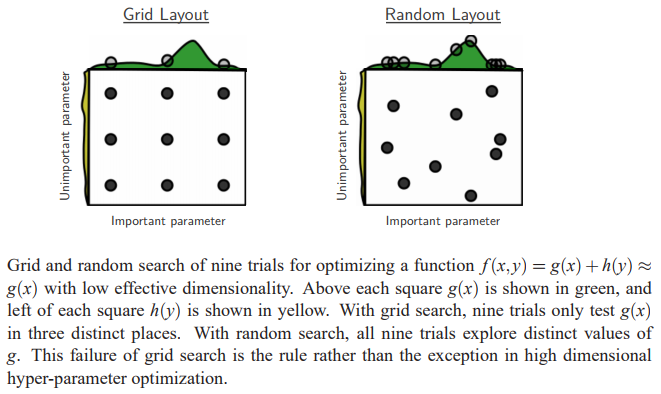


# Deep Dive to Use Neural Networks
**We will use Bi-Directional Neural Networks**

Simplifying the whole dataset to just use the BlackBox techniques of Bi-Directional Long Short Term Neural networks

In [279]:
df=df[['description','requirements','fraudulent']]

In [280]:
df.head()

,description,requirements,fraudulent
0,"Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0
1,Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0
2,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0
3,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0


###Drop Nan Values

In [281]:

df=df.dropna()
df.shape

(15185, 3)

In [282]:
X=df.drop('fraudulent',axis=1)

### Get the Independent Features

In [283]:
y=df['fraudulent']

### Get the Dependent features

In [284]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [285]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
voc_size=5000

###To process the text in nueral networks we will convert the text into One-Hot Encoding
This example can be used to understand how it converts the categorical data into a form that could be provided to ML algorithms to do a better job in prediction

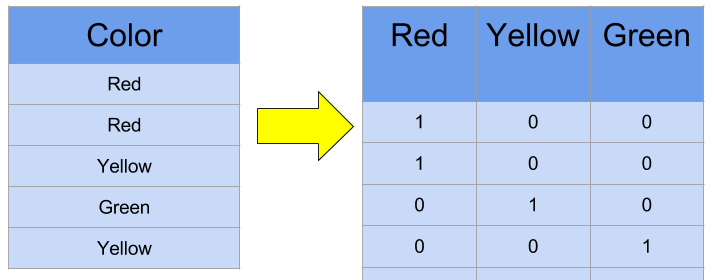

In [286]:
message = X.copy()
message['description'][1]

"Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa090 Seconds, the worlds Cloud Video Production Service -\xa0http://90

In [287]:
message.reset_index(inplace=True)

### Removing the stop words which are not useful for us before we go on to create the one hot encoding

As that will make our task redundant

In [288]:
import re
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(message)):
    review = re.sub('[^a-zA-Z]', ' ', message['description'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [289]:
corpus[1]

'organis focus vibrant awesom passion custom servic slick type skill mayb account manag think administr cooler polar bear jetski need hear cloud video product servic opper glodal level yeah pretti cool seriou deliv world class product excel custom servic rapidli expand busi look talent project manag manag success deliveri video project manag client commun drive product process work coolest brand planet learn global team repres nz huge way enter next growth stage busi grow quickli intern therefor posit burst opportun right person enter busi right time second world cloud video product servic http url fbe afac cd c f b eef e e f ca dd second world cloud video product servic enabl brand agenc get high qualiti onlin video content shot produc anywher world fast afford manag seamlessli cloud purchas publish second remov hassl cost risk speed issu work regular video product compani manag everi aspect video project beauti onlin experi grow network rate video profession countri dedic product suc

Good!! now we are going to check how our job desrciption looks like after the one hot encoding

In [304]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
print(onehot_repr[1])

[1368, 3073, 3789, 2670, 2457, 1345, 3086, 3353, 4434, 3098, 2747, 241, 3119, 4384, 3975, 1312, 193, 4791, 2734, 2008, 4700, 1386, 2645, 43, 3086, 602, 2553, 1098, 1911, 4095, 1551, 158, 1027, 1735, 95, 43, 59, 1345, 3086, 1600, 235, 3715, 4847, 753, 2963, 3119, 3119, 1154, 4629, 2645, 2963, 3119, 4668, 4763, 2657, 43, 4870, 855, 1189, 906, 4689, 214, 680, 49, 4681, 3304, 4245, 2043, 3034, 2645, 1290, 4516, 3715, 2764, 403, 4363, 2653, 1515, 3963, 2485, 1983, 4359, 3034, 3715, 1983, 1751, 3921, 1735, 1386, 2645, 43, 3086, 1966, 988, 4172, 457, 3943, 2272, 42, 1394, 3897, 2217, 2217, 42, 1214, 2718, 3921, 1735, 1386, 2645, 43, 3086, 1344, 906, 833, 4757, 1578, 1508, 1000, 2645, 4351, 4944, 1023, 1606, 1735, 89, 4143, 3119, 4389, 1386, 687, 1520, 3921, 4140, 4206, 37, 155, 355, 3964, 855, 3703, 2645, 43, 1450, 3119, 3076, 2627, 2645, 2963, 4577, 1000, 2048, 2764, 2019, 3431, 2645, 3119, 2503, 3160, 43, 1154, 49, 2503, 3007, 2645, 2963, 1154, 2300, 4695, 3445, 839, 4448, 336, 3921, 1023, 

### That's not some random text!!
Dont worry, I have got it covered! It's how the job post desription looks like after the One-hot encoding
It has given the integer value to each word from the matrix, so all the words can now be represented in the form of number.

### One more thing:
They are now looking like a sparse matric with many zeroes and few numbers 

Therefore lets convert them to a dense matrix and before that we need to convert into a numpy array and we also use pad_sequences to convert the sequence into uniform length.


---


>This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.





In [291]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[2305 4351 3119 ... 4086 1300 3985]
 [1154 2300 4695 ... 2443 3721 1072]
 [   0    0    0 ... 2608 3176  867]
 ...
 [ 796 1255 1924 ... 4499 2049 1814]
 [1146 1250 1641 ... 2752 4363 2963]
 [3455 3690 1900 ... 1749 3286 2975]]


###Word embedding

Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing where words or phrases from the vocabulary are mapped to vectors of real numbers

> Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.



Key to the approach is the idea of using a dense distributed representation for each word.

> Each word is represented by a real-valued vector, often tens or hundreds of dimensions. This is contrasted to the thousands or millions of dimensions required for sparse word representations, such as a one-hot encoding.



---
One of the benefits of using dense and low-dimensional vectors is computational: the majority of neural network toolkits do not play well with very high-dimensional, sparse vectors. … The main benefit of the dense representations is generalization power: if we believe some features may provide similar clues, it is worthwhile to provide a representation that is able to capture these similarities.


In [292]:
embedded_docs[0]

array([2305, 4351, 3119, 1709, 3348, 1232, 2429, 2643,  320,  156, 2021,
       2021,  320, 2984, 2258,  582,  320, 2019,  320, 4510, 2034, 1440,
        419, 3904, 1473, 3975,  855, 4678,  753, 4025, 3488, 2917, 3744,
       3055,  426, 4706, 1999, 4086, 1300, 3985], dtype=int32)

In [293]:
## Creating model
embedding_vector_features=50
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) ##Just add bidirectional!!, except it would just behave as normal LSTM Model
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            250000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 371,001
Trainable params: 371,001
Non-trainable params: 0
_________________________________________________________________
None


In [294]:
len(embedded_docs),y.shape

(15185, (15185,))

In [295]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [296]:
X_final[1]

array([1154, 2300, 4695, 3445,  839, 4448,  336, 3921, 1023, 2060, 2645,
       2503,  680,  906, 1070, 1735,  739, 1070, 3652, 4031, 1009, 4515,
       1975, 1473,  709, 4485, 4220, 1262, 1440, 1482,  709, 1473, 3858,
       1983, 1611, 4746,  595, 2443, 3721, 1072], dtype=int32)

In [298]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=32)

In [299]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=12,batch_size=64)


Epoch 1/12
178/178 [==============================] - 17s 96ms/step - loss: 0.1904 - accuracy: 0.9567 - val_loss: 0.1550 - val_accuracy: 0.9568
Epoch 2/12
178/178 [==============================] - 16s 89ms/step - loss: 0.0876 - accuracy: 0.9744 - val_loss: 0.1437 - val_accuracy: 0.9613
Epoch 3/12
178/178 [==============================] - 16s 89ms/step - loss: 0.0567 - accuracy: 0.9839 - val_loss: 0.1401 - val_accuracy: 0.9647
Epoch 4/12
178/178 [==============================] - 16s 89ms/step - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.1577 - val_accuracy: 0.9666
Epoch 5/12
178/178 [==============================] - 16s 88ms/step - loss: 0.0230 - accuracy: 0.9940 - val_loss: 0.1618 - val_accuracy: 0.9626
Epoch 6/12
178/178 [==============================] - 20s 113ms/step - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.1739 - val_accuracy: 0.9655
Epoch 7/12
178/178 [==============================] - 16s 89ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.2032 - val_accuracy

In [300]:
y_pred=model1.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [301]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)


array([[3546,   39],
       [ 103,  109]])

In [302]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9626020542533579

## Accuracy = 96.2%


In [303]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3585
           1       0.74      0.51      0.61       212

    accuracy                           0.96      3797
   macro avg       0.85      0.75      0.79      3797
weighted avg       0.96      0.96      0.96      3797



### Precision, Recall, F1-Score, Support
these values are more than 50% for the class 1
So we are good to go and 
>These values are better than the the logistic regression
### The Neural Network (here Bi-directional LSTM) is performing better, even without the tuning. 
### **Thats why we call it a Black Box**
